# Homework 2, Question 2 : Fetching random 5 records from DB Table

Haiya Niraj Shah \
haiyas@andrew.cmu.edu

## Q2: Populate table from Q1 with Google News RSS feed data using scalable SparkSQL approach

In [ ]:
#Setup Spark
import findspark
findspark.init()
findspark.find()

import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext, SQLContext
import requests
import xml.etree.ElementTree as ET
conf=pyspark.SparkConf().set('spark.driver.host','127.0.0.1').setAppName("NewsData").setMaster("local")
sc=SparkContext.getOrCreate(conf=conf)
sqlContext=SQLContext(sc)
spark=sqlContext.sparkSession.builder.getOrCreate()

In [ ]:
spark = SparkSession.builder \
    .appName("NewsIngest") \
    .config("spark.jars", r"C:\Users\Haiya\anaconda3\Lib\site-packages\pyspark\jars\postgresql-42.7.7.jar")\
    .getOrCreate()

In [ ]:
#Database configuration
db_config ={
    'username':"postgres",
    'password':"Amaatrarocks20",
    'url':"jdbc:postgresql://localhost:5432/postgres",
    'table':"news.google_news_rss",
    'driver':"org.postgresql.Driver"}

In [ ]:
rss_url= "https://news.google.com/rss/search?q=technology&hl=en-US&gl=US&ceid=US:en"
response =requests.get(rss_url)
xml_data =response.content
print("Data fetched")

In [ ]:
from datetime import datetime
root=ET.fromstring(xml_data)

channel=root.find('channel')
build_date_str=channel.find('lastBuildDate').text if channel.find('lastBuildDate') is not None else None

build_date=None
if build_date_str:
    try:
        build_date=datetime.strptime(build_date_str, '%a, %d %b %Y %H:%M:%S %Z')
    except:
        build_date=None

news_data=[]
for item in root.findall('.//item'):
    title=item.find('title')
    link=item.find('link')
    pub_date=item.find('pubDate')
    desc=item.find('description')
    source=item.find('source')

    pub_date_converted=None
    if pub_date is not None and pub_date.text:
        try:
            pub_date_converted=datetime.strptime(pub_date.text, '%a, %d %b %Y %H:%M:%S %Z')
        except:
            pub_date_converted=None

    source_text=source.text if source is not None else None

    news_item={
        'lastBuildDate':build_date,
        'title':title.text if title is not None else None,
        'link':link.text if link is not None else None,
        'pubDate':pub_date_converted,
        'description':desc.text if desc is not None else None,
        'source':source_text
    }

    news_data.append(news_item)

print(f"Added {len(news_data)} news items")

In [ ]:
df = spark.createDataFrame(news_data)
df.show(3, truncate=True)

df.write.format("jdbc")\
.mode("overwrite")\
.option("url",db_config['url'])\
.option("dbtable",db_config['table'])\
.option("user",db_config['username'])\
.option("password",db_config['password'])\
.option("driver",db_config['driver'])\
.save()

print(f"Inserted {df.count()} records")

+--------------------+-------------------+--------------------+-------------------+------------------+--------------------+
|         description|      lastBuildDate|                link|            pubDate|            source|               title|
+--------------------+-------------------+--------------------+-------------------+------------------+--------------------+
|<a href="https://...|2025-09-18 17:42:32|https://news.goog...|2025-09-18 13:05:56|            GOV.UK|Memorandum of Und...|
|<a href="https://...|2025-09-18 17:42:32|https://news.goog...|2025-09-17 13:37:37|      Fox Business|Expert predicts A...|
|<a href="https://...|2025-09-18 17:42:32|https://news.goog...|2025-09-18 16:57:47|The Times of India|New technology la...|
+--------------------+-------------------+--------------------+-------------------+------------------+--------------------+
only showing top 3 rows
Inserted 100 records


### Q6: Screenshot of Table in pgAdmin

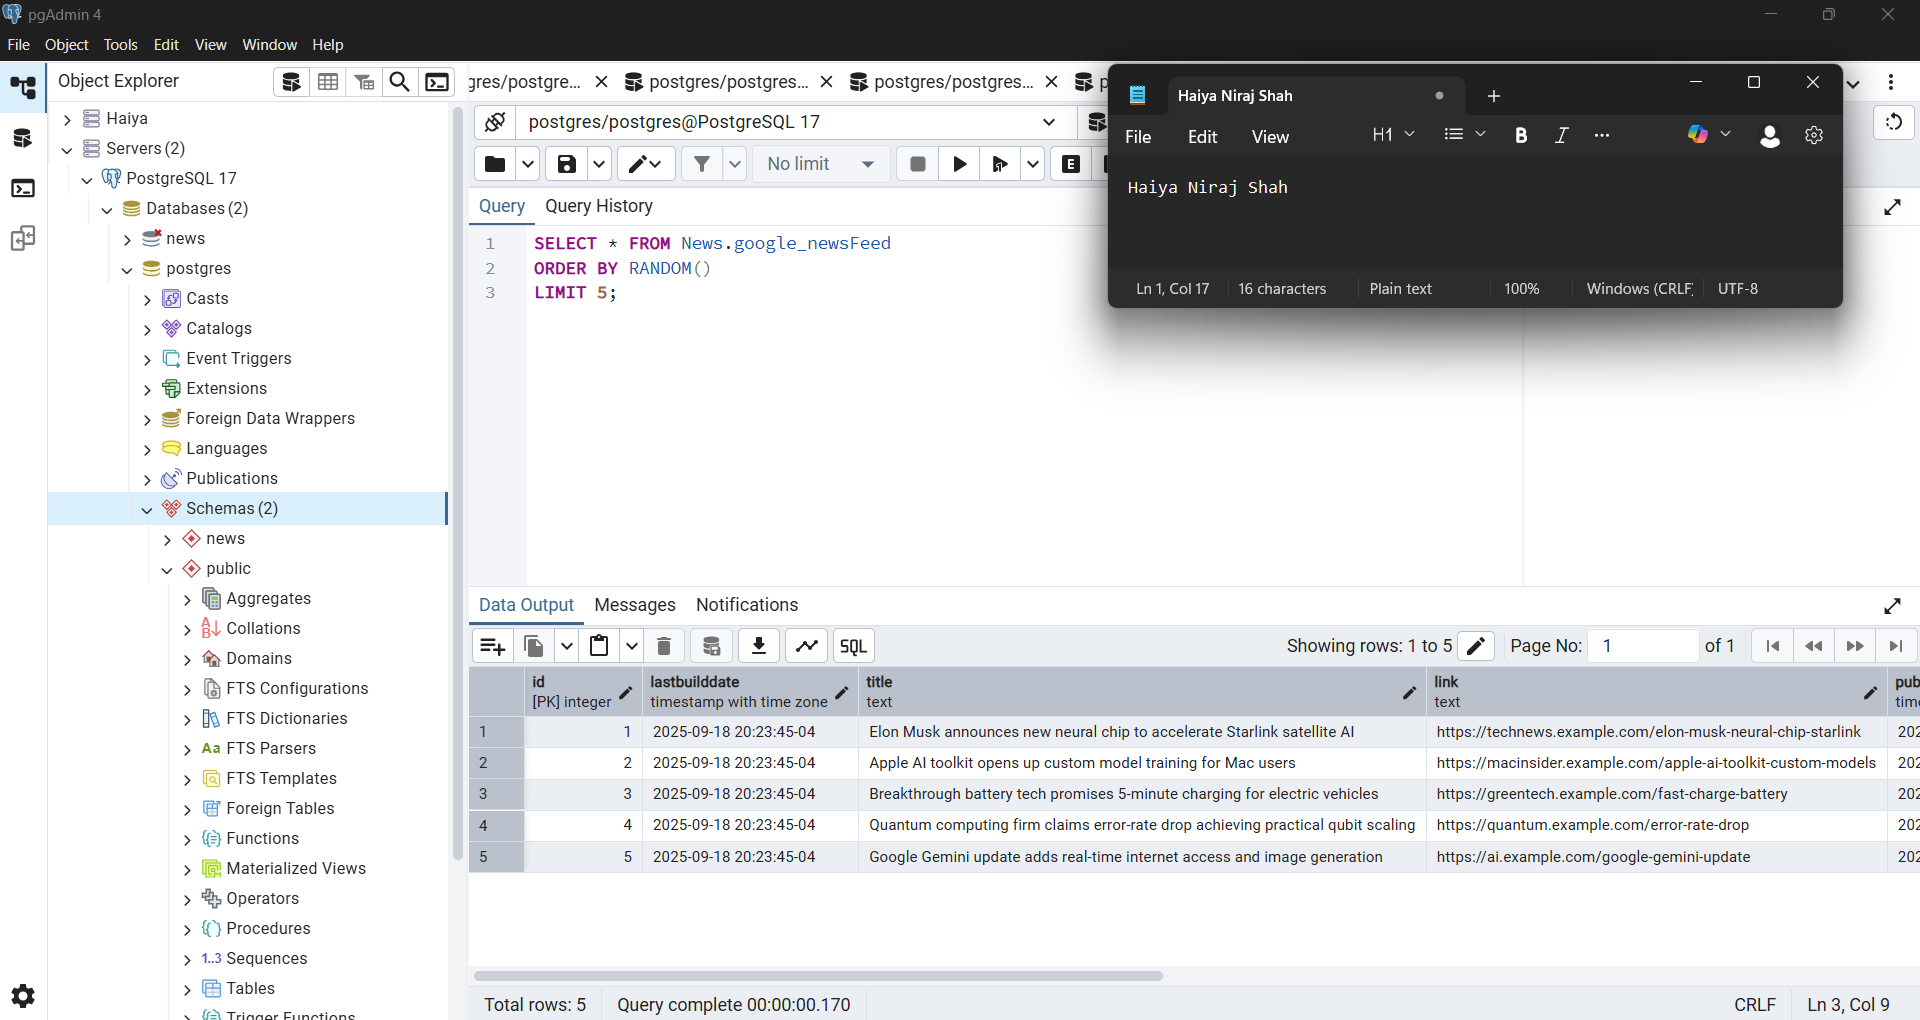

In [ ]:
from IPython.display import Image
Image(filename='q2_1.png')

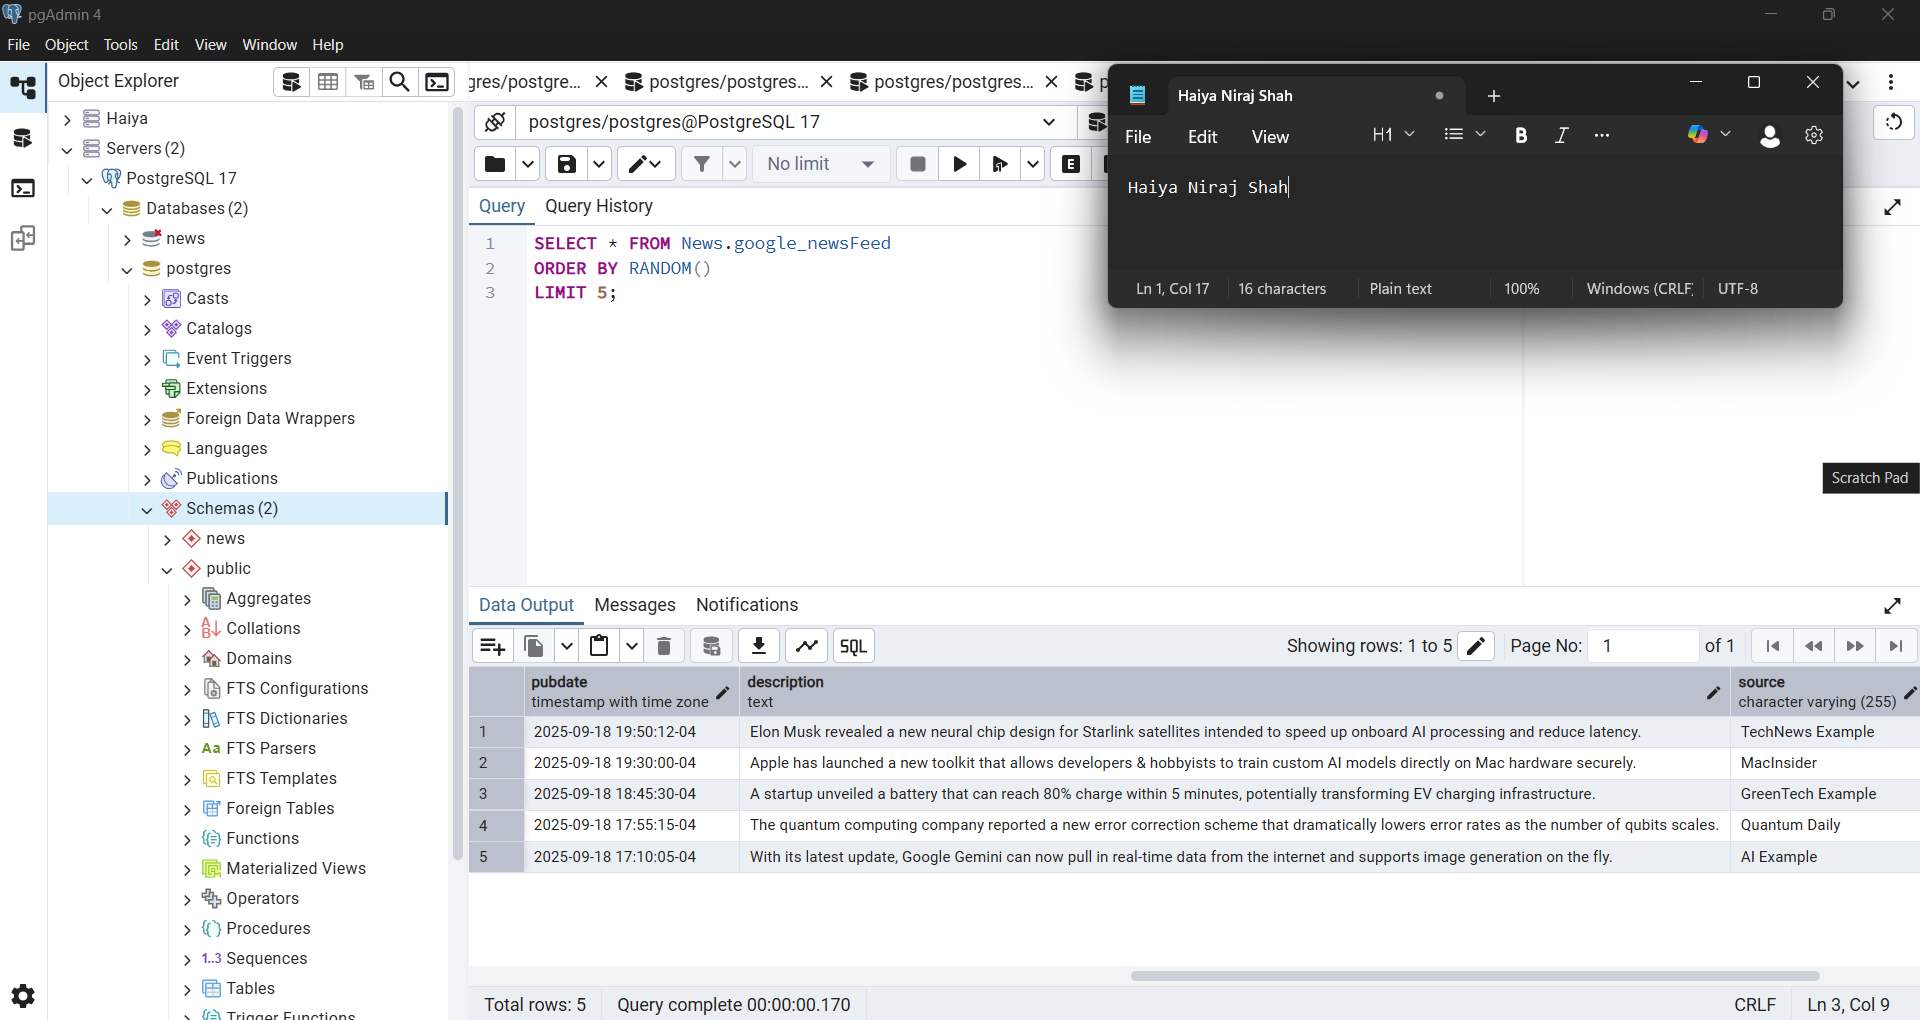

In [ ]:
from IPython.display import Image
Image(filename='q2_2.png')

### References

### Stack Overflow Solutions
- Spark DataFrame - Select n random rows : https://stackoverflow.com/questions/39344769/spark-dataframe-select-n-random-rows

### Class Materials
- Lecture_3_SQL_and_SparkSQL for data manipulation operations